## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

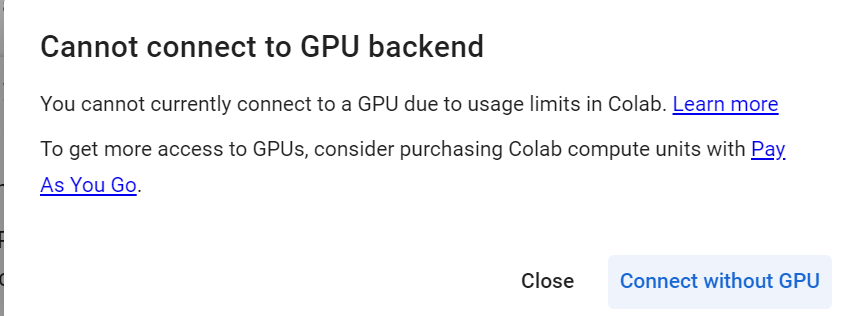

## **Installing and Importing Necessary Libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [ ]:
# Importing library for data manipulation
import pandas as pd

# Importing library for numerical operations
import numpy as np

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
# nltk.download('punkt')    # loading the punkt module used in tokenization
# nltk.download('omw-1.4')    # dependency for tokenization
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# Import the gensim library
from gensim.models import KeyedVectors

# to perform stemming
from nltk.stem.porter import PorterStemmer

# To import Word2Vec
from gensim.models import Word2Vec

# To split data into train and test sets
from sklearn.model_selection import train_test_split, GridSearchCV

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

#Import the decision tree classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

# To compute metrics to evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# To used time-related functions
import time

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# Import the necessary function from scikit-learn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## **Loading the dataset**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stock_news.csv')

## **Data Overview**

In [ ]:
# checking the first five rows of the data
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [ ]:
# checking the shape of the data
data.shape

(349, 8)

**Observations**

- Data has 349 rows and 8 columns

In [ ]:
# checking for missing values
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


**Observations**

There are no missing values in the data

In [ ]:
# checking for duplicate values
data.duplicated().sum()

0

**Observation**

- There are no duplicated data

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

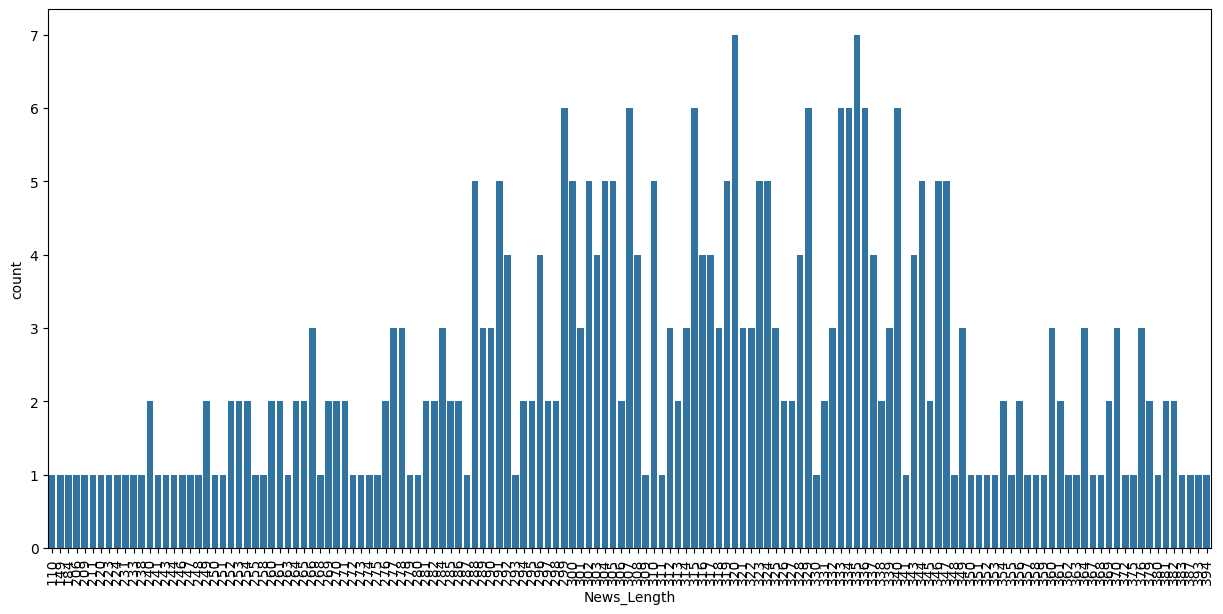

In [ ]:
# Compute the length of each news article
data['News_Length'] = data['News'].apply(len)

# Check the distribution of the length of News
plt.subplots(figsize = (15,7))
sns.countplot(data=data, x='News_Length', )
plt.xticks(rotation = 90);

**Observation**

The news length has a slightly normal distribution.

There are 7 different news contents with 320 letters and another 7 different new content with 335 letters.

<Axes: xlabel='Label', ylabel='count'>

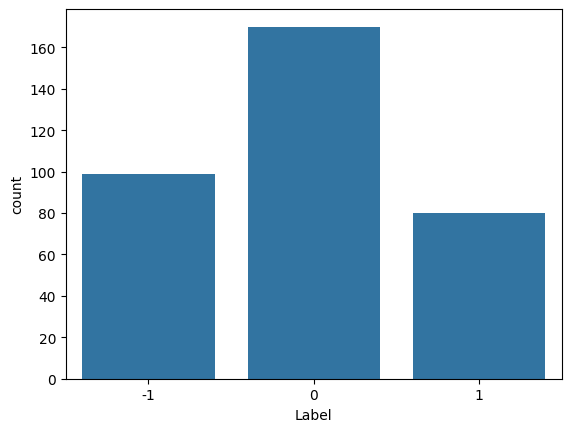

In [ ]:
# Compute the distribution of 'Label' or sentiment
sns.countplot(data=data, x='Label',)

**Observation**

There more neutral sentiments out of all, followed by negative sentiments, and lastly postive sentiments.

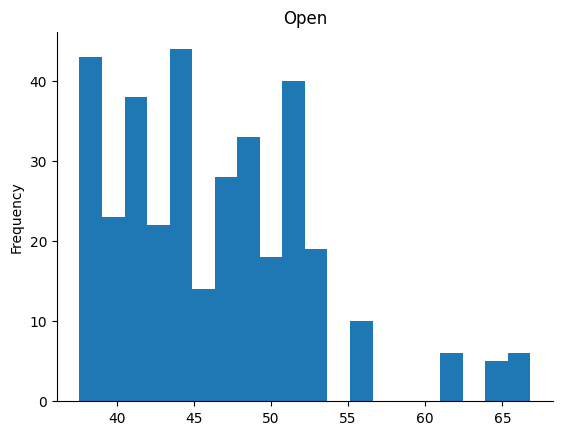

In [ ]:
# Compute the distribution of 'Open' variable
from matplotlib import pyplot as plt
data['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

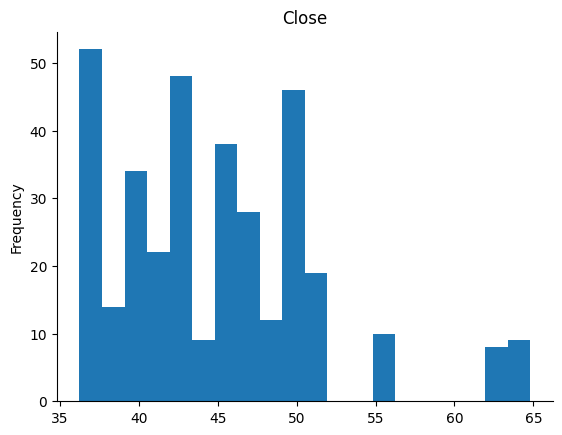

In [ ]:
# Compute the distribution of 'Open' variable
from matplotlib import pyplot as plt
data['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

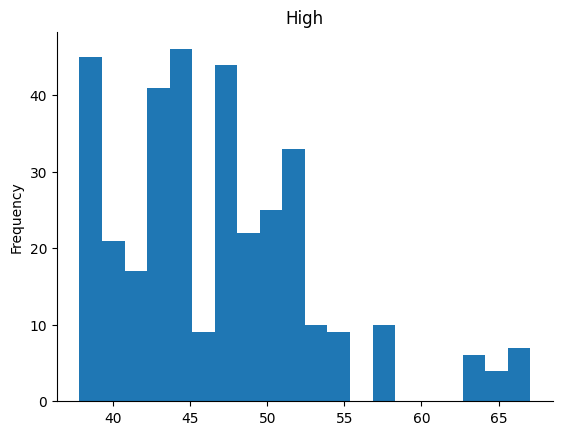

In [ ]:
# Compute the distribution of 'High' variable
from matplotlib import pyplot as plt
data['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

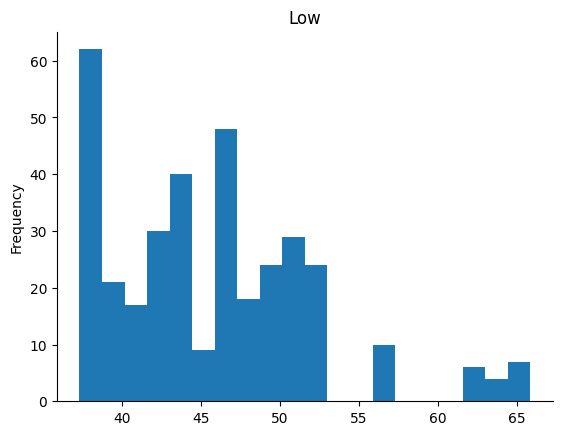

In [ ]:
# Compute the distribution of 'Low' variable
from matplotlib import pyplot as plt
data['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

**Observation**
- The histogram plots of 'high', 'low', 'open', and 'close' variables are right skewed.

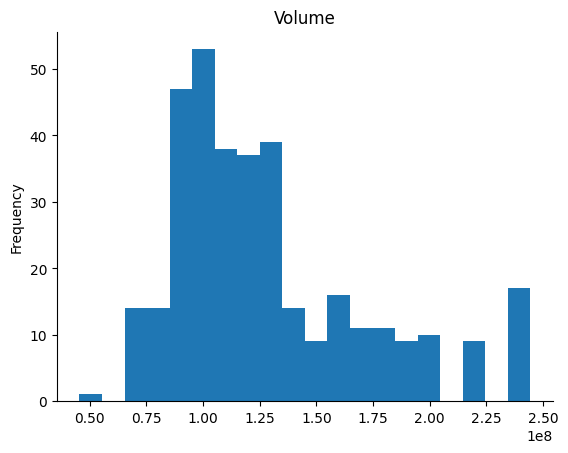

In [ ]:
# Compute the distribution of 'Volume' variable
from matplotlib import pyplot as plt
data['Volume'].plot(kind='hist', bins=20, title='Volume')
plt.gca().spines[['top', 'right',]].set_visible(False)

**Observation**
- The histogram plot of 'volume' variable is right skewed.

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

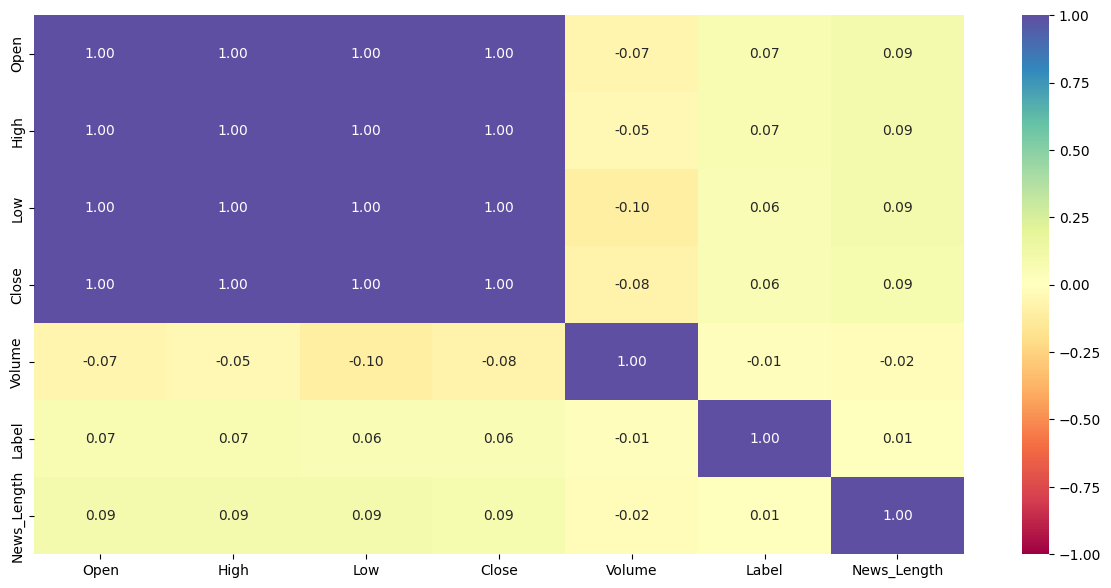

In [ ]:
# Plot the Heat Map of all the numerical attributes
numerical_data = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(15, 7))
sns.heatmap(numerical_data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations**

- The 'Open', 'High', 'Low', & ' Close' attribute have 100% collinearity amongst one another.

- 'Volume' has a negative correlation to all other variables.

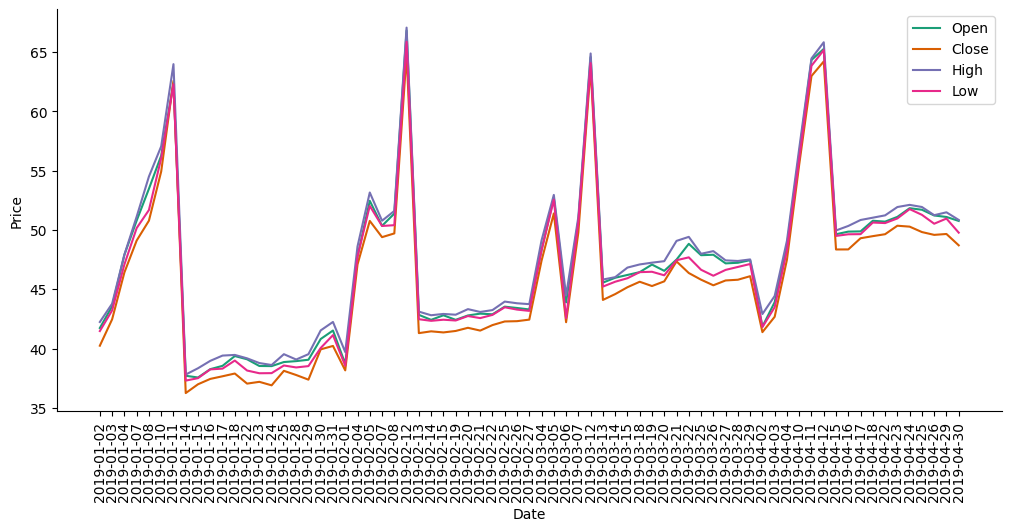

In [ ]:
# Plot Time vs Price
# Function to plot multiple series
def plot_series(series, y_columns):
    palette = sns.color_palette('Dark2', len(y_columns))
    xs = series['Date']

    # Plot each specified y_column with corresponding label and color
    for i, y_col in enumerate(y_columns):
        plt.plot(xs, series[y_col], label=y_col, color=palette[i])

# Create and sort the dataframe
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date')

# Plot 'Open', 'Close', 'High', and 'Low' on the y-axis
plot_series(df_sorted, ['Open', 'Close', 'High', 'Low'])

# Format the plot
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.legend()

# Display plot
plt.show()

**Observation**
- The Close and Open prices appear to follow a similar trend, indicating that the market doesn’t experience drastic changes overnight.
- The High and Low prices show the daily volatility, with the High prices generally being higher than the Open and Close prices, and the Low prices being lower.

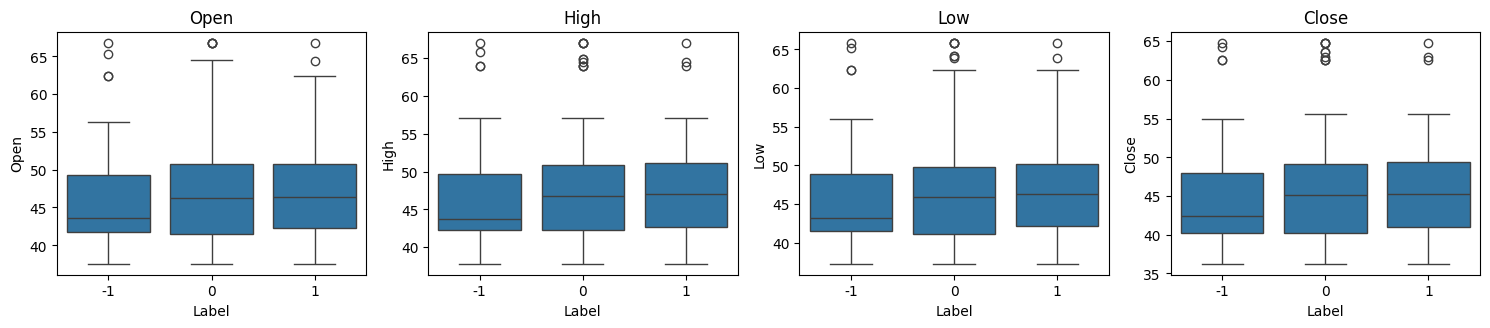

In [ ]:
# outlier detection using boxplot
price_columns = data.select_dtypes(include=['float64']).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(price_columns):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(x='Label', y=data[variable], data=data)
    #plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

**Observation**

- It evident that the median prices are typically lower with negative sentiments (-1 Label) and the median prices are generally higher with positive sentiments (1 Label).

## **Data Preprocessing**

### Removing Special Characters

In [ ]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = "[^A-Za-z0-9']+"

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))


    # Remove apostrophes as well, uncomment the following line:
    new_text = new_text.replace("'", "")

    # Return the processed text
    return new_text

In [ ]:
# Applying the function to remove special characters
data['cleaned_text'] = data['News'].apply(remove_special_characters)

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,The tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,Apple lowered its fiscal Q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,Apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,This news article reports that yields on long...


### Lowercasing

In [ ]:
# changing the case of the text data to lower case
data['cleaned_text'] = data['cleaned_text'].str.lower()

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,the tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,this news article reports that yields on long...


### Removing Extra Whitespace

In [ ]:
# removing extra whitespaces from the text
data['cleaned_text'] = data['cleaned_text'].str.strip()

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:6, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,the tech sector experienced a significant decl...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance t...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue for...
3,This news article reports that yields on long...,this news article reports that yields on long ...
4,Apple's revenue warning led to a decline in U...,apples revenue warning led to a decline in usd...
5,Apple CEO Tim Cook discussed the company's Q1 ...,apple ceo tim cook discussed the companys q1 w...
6,Roku Inc has announced plans to offer premium...,roku inc has announced plans to offer premium ...


### Remove Stopword
- Remove stop wors and words that appear frequently throughout the document in the corpus.

In [ ]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [ ]:
# Applying the function to remove stop words using the NLTK library
data['cleaned_text_without_stopwords'] = data['cleaned_text'].apply(remove_stopwords)

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

,cleaned_text,cleaned_text_without_stopwords
0,the tech sector experienced a significant decl...,tech sector experienced significant decline af...
1,apple lowered its fiscal q1 revenue guidance t...,apple lowered fiscal q1 revenue guidance 84 bi...
2,apple cut its fiscal first quarter revenue for...,apple cut fiscal first quarter revenue forecas...
3,this news article reports that yields on long ...,news article reports yields long dated u treas...


### Stemming
Shorten words to their root form by removing suffixes

In [ ]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [ ]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [ ]:
# Applying the function to perform stemming
data['final_cleaned_text'] = data['cleaned_text_without_stopwords'].apply(apply_porter_stemmer)

In [ ]:
# checking a couple of instances of cleaned data
data.loc[0:2,['cleaned_text_without_stopwords','final_cleaned_text']]

,cleaned_text_without_stopwords,final_cleaned_text
0,tech sector experienced significant decline af...,tech sector experienc signific declin aftermar...
1,apple lowered fiscal q1 revenue guidance 84 bi...,appl lower fiscal q1 revenu guidanc 84 billion...
2,apple cut fiscal first quarter revenue forecas...,appl cut fiscal first quarter revenu forecast ...


### Train-test-validation split

In [ ]:
# Set independent variables for training, testing, & validation
X_train = data[(data['Date'] < '2019-04-01')].reset_index()
X_val = data[(data['Date'] >= '2019-04-01') & (data['Date'] < '2019-04-16')].reset_index()
X_test = data[data['Date'] >= '2019-04-16'].reset_index()

In [ ]:
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

In [ ]:
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 13)
Validation data shape (21, 13)
Test data shape  (42, 13)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


## **Word Embeddings**

### Word2Vec
Utilize Word2Vec imported from Gensim Library

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in data['final_cleaned_text'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2584


In [ ]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([ 2.76262639e-03,  1.11666722e-02,  7.53280940e-04,  6.75618183e-03,
       -1.21836818e-03, -1.40512437e-02,  1.04319816e-02,  2.23639812e-02,
        3.42123630e-03, -3.38197756e-03,  4.93674539e-04, -9.38953180e-03,
        6.18648017e-04,  1.76170375e-03, -1.03568174e-02, -9.25497990e-03,
        6.25809981e-03, -2.18637288e-04,  4.91700089e-03, -4.15874412e-03,
       -8.04575533e-03, -1.20028586e-03,  1.18762590e-02,  1.24635373e-03,
        1.37809450e-02,  8.77746090e-04, -1.17474878e-02, -3.54965008e-03,
       -7.16728624e-03, -1.23104015e-02,  5.94481500e-03, -1.95524748e-03,
       -1.16425636e-03,  8.03396164e-04, -5.37702441e-03,  5.81265148e-03,
        1.24121970e-03, -1.28081180e-02, -5.95186721e-04, -5.23919240e-03,
       -3.55151645e-03,  9.44978383e-04,  4.16125776e-03, -9.51737072e-03,
        6.57688873e-03,  1.39023010e-02,  1.04157906e-03,  2.33572652e-03,
       -3.63727706e-03,  1.02747884e-02,  4.68374090e-03,  1.44840466e-04,
       -9.89731494e-03,  

In [ ]:
# Checking top 5 similar words to the word 'good' using Cosine Similarity
similar = model_W2V.wv.similar_by_word('stock', topn=5)
print(similar)

[('appl', 0.9552979469299316), ('trade', 0.9426391124725342), ('u', 0.9330386519432068), ('compani', 0.9309584498405457), ('report', 0.9293896555900574)]


In [ ]:
# Checking the word embedding of a random word
word = "revenu"
model_W2V.wv[word]

array([ 8.90790019e-04,  1.17203016e-02, -8.29688652e-05,  6.54727500e-03,
        1.57457963e-03, -1.13057429e-02,  8.40943679e-03,  1.53373098e-02,
        5.62178995e-03, -5.01638802e-04,  3.23849235e-04, -1.10120336e-02,
        7.03496480e-05,  1.68119106e-04, -8.52989312e-03, -9.62606166e-03,
        4.87749092e-03, -4.51485394e-03,  1.52123114e-03,  2.30552536e-03,
       -9.29965824e-03,  3.17505421e-03,  7.18998583e-03,  2.35033105e-03,
        9.13057197e-03, -1.52820454e-03, -1.17426375e-02, -1.49880582e-03,
       -7.60509400e-03, -1.07636182e-02,  5.83041506e-03, -6.18812349e-03,
       -2.81770620e-03, -2.09713681e-03, -4.84100496e-03,  1.49268471e-03,
        2.54851044e-03, -4.15483024e-03,  3.93730914e-03, -3.39669897e-03,
       -7.70843402e-03,  1.44053949e-03, -2.11680355e-03, -7.57622300e-03,
        2.16444791e-03,  9.55650769e-03,  6.45939144e-04,  5.18336147e-03,
       -9.33932024e-04,  1.08859213e-02,  3.13719758e-03, -7.11968576e-04,
       -3.53594939e-03, -

In [ ]:
# Checking top 5 similar words to the word 'best'
similar = model_W2V.wv.similar_by_word('revenu', topn=5)
print(similar)

[('appl', 0.9355588555335999), ('compani', 0.9158378839492798), ('trade', 0.9154180288314819), ('stock', 0.9140524864196777), ('u', 0.9126055836677551)]


In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))


Time taken  0.6695449352264404


In [ ]:
# Display the shape of word embedded dataframe
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


In [ ]:
# Display vectorized dataframe for training set
X_train_wv

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 290,Feature 291,Feature 292,Feature 293,Feature 294,Feature 295,Feature 296,Feature 297,Feature 298,Feature 299
0,0.000164,0.003203,-0.001377,0.001730,-0.001681,-0.005216,0.002438,0.007325,0.000832,-0.000454,...,-0.000824,0.004693,0.002098,0.000751,0.003301,0.005316,0.000206,-0.003902,0.003971,-0.001324
1,0.000606,0.006096,0.000611,0.003606,-0.001379,-0.008332,0.004468,0.012651,0.002279,-0.000438,...,-0.001103,0.006399,0.005726,0.001618,0.005286,0.006618,0.000427,-0.003345,0.005657,-0.001601
2,0.000101,0.004805,0.001468,0.004185,-0.001208,-0.008110,0.003902,0.011134,0.001943,-0.000315,...,-0.001167,0.006568,0.005863,0.001336,0.004815,0.006562,0.001521,-0.004395,0.005507,-0.001189
3,-0.000807,0.005848,0.000065,0.003182,0.000293,-0.005812,0.003157,0.009484,0.001763,-0.001518,...,-0.000926,0.004518,0.004708,0.000930,0.003915,0.006049,0.000988,-0.002760,0.003843,-0.000722
4,0.000144,0.003629,-0.000702,0.002543,-0.001182,-0.004952,0.001707,0.006401,0.001398,0.000527,...,-0.000694,0.003200,0.002929,0.001510,0.002955,0.003143,0.000603,-0.001883,0.002018,-0.000304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,-0.001149,0.006647,0.000419,0.003100,0.000307,-0.007019,0.004757,0.010252,0.002164,0.000224,...,-0.000062,0.006422,0.003186,0.000974,0.003415,0.005575,0.000324,-0.002229,0.005795,-0.001519
282,0.000769,0.005193,0.000628,0.003422,0.000080,-0.007681,0.004718,0.012018,0.001279,-0.001854,...,-0.000722,0.006493,0.006146,0.002240,0.005641,0.006289,0.000756,-0.003700,0.004171,-0.000347
283,0.001149,0.002951,0.000626,0.002860,-0.001228,-0.004255,0.001101,0.007301,0.001316,-0.000024,...,0.000126,0.003474,0.002515,0.000004,0.002653,0.003261,-0.000872,-0.002754,0.003750,-0.001052
284,0.000218,0.002899,0.000086,0.001339,0.000238,-0.004868,0.002496,0.007705,0.000444,0.000182,...,-0.000222,0.002725,0.003822,0.001180,0.003834,0.004411,-0.001163,-0.003015,0.003714,-0.001762


### GloVe

In [ ]:
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [ ]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  34.26355528831482


In [ ]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


### Sentence Transformer

Defining the model

In [ ]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding the dataset

In [ ]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)
end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  1.9190049171447754


In [ ]:
# Display the shape of transformer-encoded vectorized dataframe
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


**Observation**

- They have been converted into a 384-dimensional vector

In [ ]:
# Display transformer-encoded vectorized dataframe for training set
X_train_st

array([[-0.00202309, -0.03677354,  0.07735426, ..., -0.1315021 ,
         0.07416345,  0.05751003],
       [ 0.01374942,  0.04893395,  0.08986831, ..., -0.12378194,
         0.0614684 ,  0.00392387],
       [ 0.03097601,  0.00263555,  0.09013866, ..., -0.11130109,
         0.01141429,  0.07881161],
       ...,
       [ 0.00749305, -0.00308262, -0.04878728, ..., -0.11774463,
        -0.00549962,  0.03768522],
       [-0.10636733,  0.07484969,  0.10435312, ..., -0.04722221,
         0.15853965,  0.05964362],
       [-0.05155855,  0.07411481,  0.00082973, ..., -0.05100621,
         0.0157598 ,  0.07734218]], dtype=float32)

## **Sentiment Analysis**

### Utility Functions

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [ ]:
# Building the model
base_wv = RandomForestClassifier(random_state = 42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

RandomForestClassifier(random_state=42)

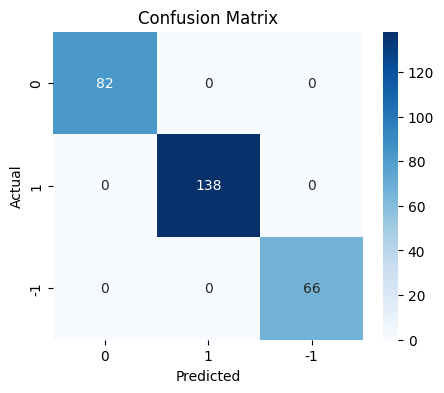

In [ ]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

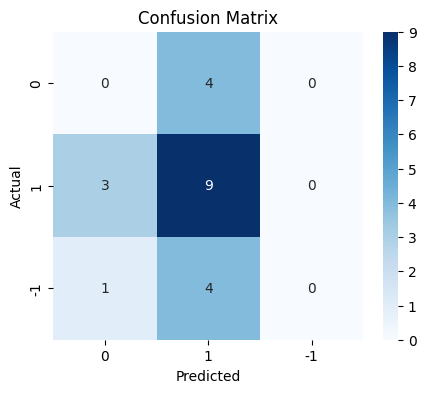

In [ ]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [ ]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision       F1
0  0.428571  0.428571   0.302521  0.35468


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Base Model - GloVe

In [ ]:
#Building the model
base_gl = RandomForestClassifier(random_state = 42)


# Fitting on train data
base_gl.fit(X_train_gl, y_train)

RandomForestClassifier(random_state=42)

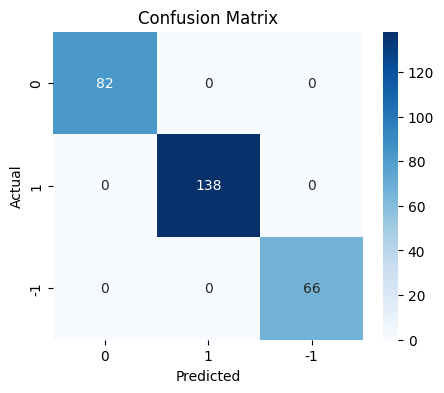

In [ ]:
plot_confusion_matrix(base_gl, X_train_gl, y_train)

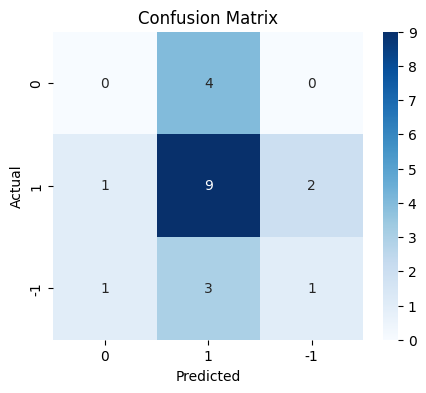

In [ ]:
plot_confusion_matrix(base_gl, X_val_gl, y_val)

In [ ]:
#Calculating different metrics on training data
base_train_gl=model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.400794  0.426871


### Base Model - Sentence Transformer

In [ ]:
# Building the model
base_st = DecisionTreeClassifier(random_state = 42)

# Fitting on train data
base_st.fit(X_train_st, y_train)

DecisionTreeClassifier(random_state=42)

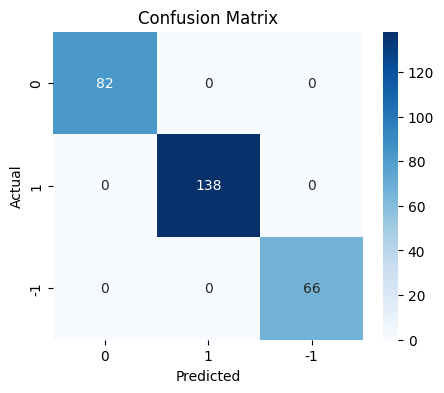

In [ ]:
plot_confusion_matrix(base_st,X_train_st,y_train)

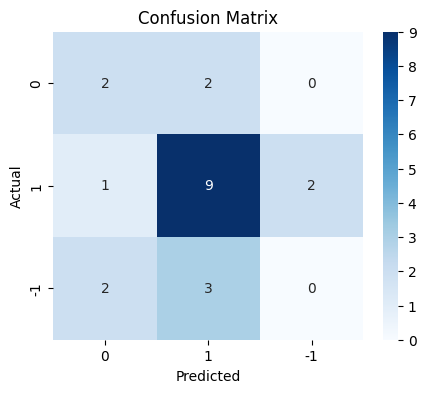

In [ ]:
plot_confusion_matrix(base_st,X_val_st,y_val)

In [ ]:
#Calculating different metrics on training data
base_train_st=model_performance_classification_sklearn(base_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy   Recall  Precision       F1
0   0.52381  0.52381   0.443537  0.48026


### Tuned Model - Word2Vec

In [ ]:
# Building the model
start = time.time()
tuned_wv = RandomForestClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  138.79206776618958


In [ ]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=6, max_features='log2', min_samples_split=7,
                       random_state=42)

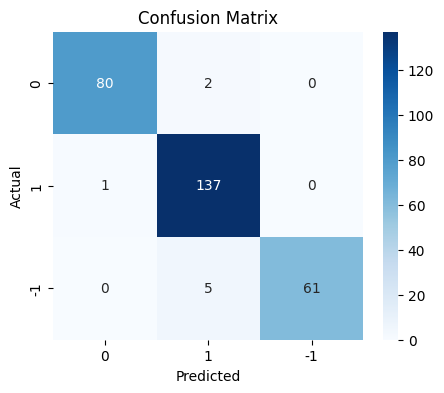

In [ ]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

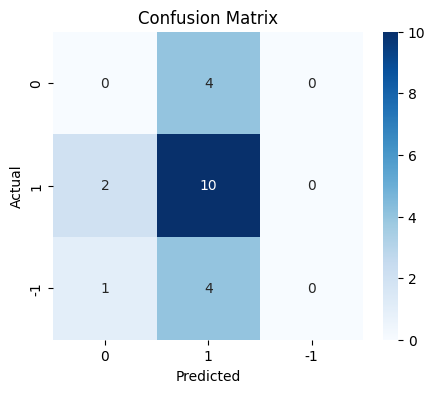

In [ ]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [ ]:
#Calculating different metrics on training data
tuned_train_wv = model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n", tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.972028  0.972028   0.973005  0.971949


In [ ]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619    0.31746  0.380952


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Tuned Model - GloVe

In [ ]:
# Building the model
start = time.time()
tuned_gl = RandomForestClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Time taken  81.71083521842957


In [ ]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=7,
                       random_state=42)

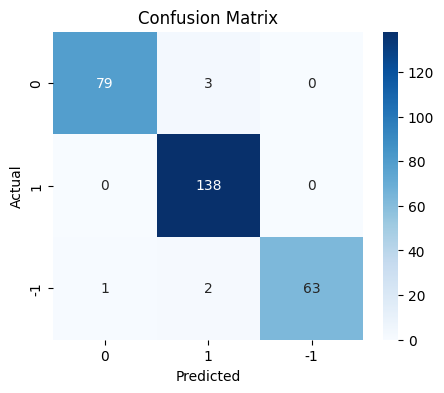

In [ ]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

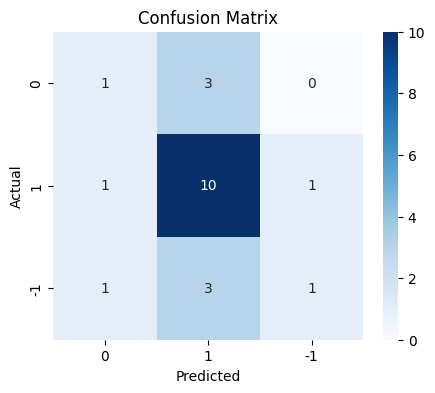

In [ ]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [ ]:
#Calculating different metrics on training data
tuned_train_gl = model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n", tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.979021  0.979021   0.979545  0.978968


In [ ]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619    0.31746  0.380952


### Tuned Model - Sentence Transformer

In [ ]:
# Building the model
start = time.time()
tuned_st = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  3.63472318649292


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train)

DecisionTreeClassifier(max_depth=5, max_features=0.4, min_samples_split=11,
                       random_state=42)

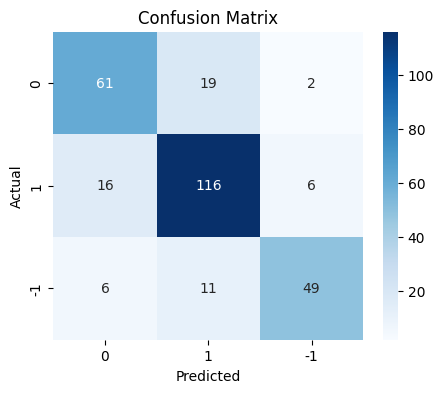

In [ ]:
plot_confusion_matrix(tuned_st,X_train_st,y_train)

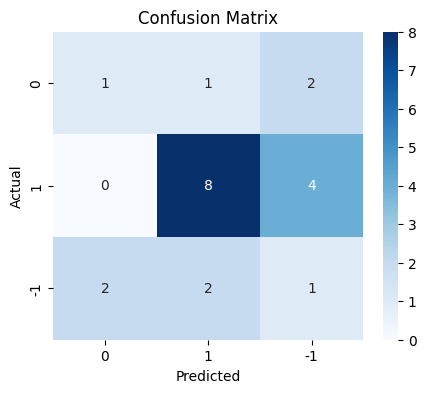

In [ ]:
plot_confusion_matrix(tuned_st,X_val_st,y_val)

In [ ]:
#Calculating different metrics on training data
tuned_train_st = model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n", tuned_train_st)

Training performance:
    Accuracy   Recall  Precision        F1
0   0.79021  0.79021   0.792468  0.790028


In [ ]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy   Recall  Precision       F1
0   0.47619  0.47619    0.51309  0.49162


### Model Performances & Model Selection

In [ ]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,0.972028,0.979021,0.790210
Recall,1.0,1.0,1.0,0.972028,0.979021,0.790210
Precision,1.0,1.0,1.0,0.973005,0.979545,0.792468
F1,1.0,1.0,1.0,0.971949,0.978968,0.790028


In [ ]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.428571,0.476190,0.523810,0.476190,0.571429,0.47619
Recall,0.428571,0.476190,0.523810,0.476190,0.571429,0.47619
Precision,0.302521,0.400794,0.443537,0.317460,0.539683,0.51309
F1,0.354680,0.426871,0.480260,0.380952,0.530612,0.49162


**Observation**
- The **Tuned Model (GloVe)** has the highest accuracy (0.571429), recall (0.571429), and F1 score (0.530612), indicating a well-balanced performance with good precision (0.539683).
- It shows significant improvement over base models and is suitable for applications requiring high recall and balanced precision, even with a moderate number of false positives.

### Check Selected Model on Test Data
**Tuned Model (GloVe)**

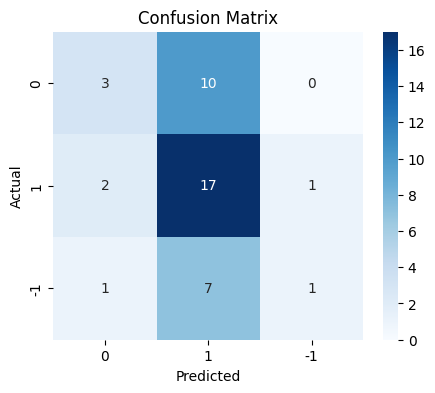

In [ ]:
plot_confusion_matrix(tuned_gl,X_test_gl,y_test)

In [ ]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(tuned_gl,X_test_gl,y_test) #Complete the code to compute the final model's performance for the test data
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy  Recall  Precision        F1
0       0.5     0.5        0.5  0.436529


**Observation**
- The final model shows balanced accuracy, recall, and precision at 0.5 each, but the F1 score is slightly lower at 0.436529.
- While the model is consistent in identifying relevant instances and minimizing false positives, the lower F1 score suggests there might be room for improvement in balancing precision and recall.

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stock_news.csv')

#### Loading the model

In [ ]:
# Load Mistral model
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

In [ ]:
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [ ]:
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=4500, #Context window
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
# Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=512,
      temperature=0,
      top_p=0.95,
      top_k=50,
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output



##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
news = data_1.loc[8, 'News']

In [ ]:
print(len(news.split(' ')))
news

422


" The Dow Jones Industrial Average and other major indexes posted gains on Monday, with the Dow rising 60 points, after President Trump announced progress in trade talks with China and delayed tariff hikes. Trade-sensitive stocks like Boeing and Caterpillar performed well, but some tariffs are expected to remain as an enforcement mechanism ||  AAC Technologies Holdings, an Apple supplier based in Hong Kong, reported a significant decrease in expected net profit for Q1 2019 due to reduced orders from customers. The company forecasted a profit decline of 65-75% compared to the same period last year and narrowing gross profit margins. AAC ||  Huawei, the world's third-largest smartphone vendor, showcased its new folding phone, the Mate X, on February 24. The device is designed for next-generation 5G networks and promises super-fast internet speeds. Despite US efforts to exclude the Chinese company from 5G networks ||  Sony, aiming to differentiate itself in the smartphone market, unveiled

In [ ]:
# prompt for this task
prompt = """
    You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
"""

In [ ]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

llama_perf_context_print:        load time =  412407.80 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   799 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   213 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  599358.94 ms /  1012 tokens


 [
        1: "Trade Talks between US and China",
        2: "President Trump's Announcement on Tariff Hikes and Trade-sensitive Stocks",
        3: "AAC Technologies Holdings' Decrease in Net Profit and Reduced Orders",
        4: "Huawei's New Folding Phone and US Efforts to Exclude the Company from 5G Networks",
        5: "Sony's New Flagship Xperia 1 and Berkshire Hathaway's Unexpected Exit from Oracle Corp",
        6: "Huawei's Defense of Position Amid US-China Trade Tensions",
        7: "AAC Technologies Holdings Inc's Decrease in First-Quarter Profits",
        8: "Apple's Layoffs in Project Titan",
        9: "Spotify's Entry into Indian Market"
      ]
CPU times: user 14min 39s, sys: 1.51 s, total: 14min 40s
Wall time: 9min 59s


##### Checking the model output on the weekly data

In [ ]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 146 prefix-match hit, remaining 3744 prompt tokens to eval
llama_perf_context_print:        load time =  412407.80 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  3744 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   220 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time = 2348554.33 ms /  3964 tokens
 11%|█         | 2/18 [39:08<5:13:08, 1174.29s/it]Llama.generate: 145 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time =  412407.80 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2234 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   343 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time = 1531276.85 ms /  2577

CPU times: user 8h 19min 11s, sys: 1min 9s, total: 8h 20min 21s
Wall time: 5h 44min 13s


In [ ]:
data_1['Key Events'].head()

,Key Events
0,"[\n {\n ""topic_1"": ""Apple's Q..."
1,"[\n {\n ""topic_1"": ""5G Smar..."
2,"[\n {\n ""topic_1"": ""U.S. stoc..."
3,"[\n {\n ""topic_1"": ""Swiss N..."
4,"[\n {\n ""topic_number"": 1,\n ..."


##### Formatting the model output

In [ ]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

Error parsing JSON: Extra data: line 4 column 11 (char 273)
Error parsing JSON: Extra data: line 5 column 10 (char 284)
Error parsing JSON: Extra data: line 4 column 11 (char 167)
Error parsing JSON: Extra data: line 4 column 11 (char 257)
Error parsing JSON: Extra data: line 4 column 11 (char 199)
        1: "Trade Talks between US and China",
        2: "President Trump's Announcement on Tariff Hikes and Trade-sensitive Stocks",
        3: "AAC Technologies Holdings' Decrease in Net Profit and Reduced Orders",
        4: "Huawei's New Folding Phone and US Efforts to Exclude the Company from 5G Networks",
        5: "Sony's New Flagship Xperia 1 and Berkshire Hathaway's Unexpected Exit from Oracle Corp",
        6: "Huawei's Defense of Position Amid US-China Trade Tensions",
        7: "AAC Technologies Holdings Inc's Decrease in First-Quarter Profits",
        8: "Apple's Layoffs in Project Titan",
        9: "Spotify's Entry into Indian Market"
      ]
        1,
        "Spotify's 

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"[\n {\n ""topic_1"": ""Apple's Q...",{'topic_1': 'Apple's Q1 revenue warning and it...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"[\n {\n ""topic_1"": ""5G Smar...","{'topic_1': '5G Smartphones', 'topic_2': 'AMS ..."
2,2019-01-20,The U.S. stock market declined on Monday as c...,"[\n {\n ""topic_1"": ""U.S. stoc...","{'topic_1': 'U.S. stock market', 'topic_2': 'G..."
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","[\n {\n ""topic_1"": ""Swiss N...",{}
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"[\n {\n ""topic_number"": 1,\n ...",{}


In [ ]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_23,topic_24,topic_25,1,2,3,4,5,6,7
0,Apple's Q1 revenue warning and its impact on t...,Global economic concerns following weak econom...,Impact of US-China trade tensions on Apple and...,Safe haven assets like Japanese yen and gold g...,Slowing Chinese economy and its impact on US f...,Record investments in gold due to economic dow...,Trade talks between US and China and their pot...,Patent infringement case between Qualcomm and ...,China's economic weakness and its potential im...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5G Smartphones,AMS Sensor Technology,Apple and AMS Partnership,Vivendi and Universal Music Group Valuation,Amazon Stock Prediction,AMS-Face 3D Facial Recognition,Geely Sales Forecast,US-China Trade War,Qualcomm Car Computing Chips,Mercedes Benz Sales,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U.S. stock market,Global economic slowdown,China's exports and imports,Technology stocks,Philadelphia SE Semiconductor Index,European stock market,Luxury retailers,Chinese auto market,Apple's self-driving vehicle program,Qualcomm patent lawsuit against Apple,...,Belarus cryptocurrency platform,Apple and Qualcomm patent dispute,US-China trade talks,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
# Get the existing column count
num_columns = len(final_output.columns)
# Create a list of new column names with the correct length
new_column_names = ['Week End Date', 'News'] + [f'Column_{i}' for i in range(2, num_columns)]
# Assign the new column names
final_output.columns = new_column_names

final_output.head()

,Week End Date,News,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,...,Column_24,Column_25,Column_26,Column_27,Column_28,Column_29,Column_30,Column_31,Column_32,Column_33
0,2019-01-06,The tech sector experienced a significant dec...,Apple's Q1 revenue warning and its impact on t...,Global economic concerns following weak econom...,Impact of US-China trade tensions on Apple and...,Safe haven assets like Japanese yen and gold g...,Slowing Chinese economy and its impact on US f...,Record investments in gold due to economic dow...,Trade talks between US and China and their pot...,Patent infringement case between Qualcomm and ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,5G Smartphones,AMS Sensor Technology,Apple and AMS Partnership,Vivendi and Universal Music Group Valuation,Amazon Stock Prediction,AMS-Face 3D Facial Recognition,Geely Sales Forecast,US-China Trade War,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-20,The U.S. stock market declined on Monday as c...,U.S. stock market,Global economic slowdown,China's exports and imports,Technology stocks,Philadelphia SE Semiconductor Index,European stock market,Luxury retailers,Chinese auto market,...,Belarus cryptocurrency platform,Apple and Qualcomm patent dispute,US-China trade talks,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Conclusions and Recommendations**

- From the exploratory data analysis (EDA) conducted on the dataset, we observed a positive correlation between news sentiments and stock prices. Positive sentiments often lead to an increase in stock prices, and vice versa.
- We developed models using Word2Vec, GloVe, and Sentence Transformers to classify news into various sentiment categories.
- Among the base and tuned models, the GloVe model with a Random Forest classifier performed the best on validation and testing data, achieving accuracy, recall, and precision scores of 0.5 each. However, the F1 score was slightly lower at 0.436529.
- Additionally, we implemented an automated process to analyze stock-related news headlines using a Large Language Model (LLM) from the Mistral-7B model, categorizing them into key positive and negative events likely to impact stock prices.
- We can enhance our responses by making our prompts more specific and fine-tuning certain parameters in our model.


<font size=6 color='blue'>Power Ahead</font>
___

In [3]:
!apt-get install -y jq
!jq -M 'del(.metadata.widgets)' /content/NLP_Project_Full_Code.ipynb > /content/NLP_Project_Full_Code_clean.ipynb
!jupyter nbconvert --to html /content/NLP_Project_Full_Code_clean.ipynb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
jq is already the newest version (1.6-2.1ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
[NbConvertApp] Converting notebook /content/NLP_Project_Full_Code_clean.ipynb to html
[NbConvertApp] Writing 1709228 bytes to /content/NLP_Project_Full_Code_clean.html


In [ ]:
!